# Описание бизнес-задачи:

Прогнозирование продаж товаров на 1 неделю вперед. Оценка точности прогноза.

Есть данные о продаже разных категорий товаров в крупном магазине по дням и по часам. В этих данных есть следующие колонки:

- `category_id` - id категории
- `date` - дата
- `hour` - час, за который отсчитывается число продаж
- `num_sells_in_hour` - число продаж этого товара за один час

Данные взяты из kaggle-соревнования

# Что буду делать?:

- Определю тренд.

- Посмотрю на внутридневную и внутринедельную сезонности.

- Проверю какой алгоритм по метрикам качества сможет лучше строить прогноз.
  Применю и сравню по метрикам качества два подхода: линейную регрессию и Prophet. Линейная регрессия - это простой метод регрессии, а Prophet хорошо подходит для временных рядов.

- Результат оценю с помощью Mean Squared Error (MSE) и Mean Absolute Error (MAPE).

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle_retail_competition.csv to kaggle_retail_competition (1).csv


In [192]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, timezone
from matplotlib import pyplot as plt
from fbprophet import Prophet
from sklearn import preprocessing, svm 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score
from IPython import display

In [193]:
df = pd.read_csv('kaggle_retail_competition.csv')

In [194]:
df.head()

,category_id,date,hour,num_sells_in_hour
0,8940,2018-05-25,8,16
1,8940,2018-05-25,9,22
2,8940,2018-05-25,10,15
3,8940,2018-05-25,11,24
4,8940,2018-05-25,12,22


In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97047 entries, 0 to 97046
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category_id        97047 non-null  int64 
 1   date               97047 non-null  object
 2   hour               97047 non-null  int64 
 3   num_sells_in_hour  97047 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3.0+ MB


In [196]:
df['date'].nunique()

37

### Есть данные о продажах за 37 дней. Для прогнозирования планирую проверить два подхода: Линейную регрессию и Profhet. Для линейной регрессии понадобятся полные недели. Поэтому первые два дня удалю.

In [197]:
data_sort = np.sort(df['date'].unique())

In [198]:
df_35day = df[(df['date'] != data_sort[0]) & (df['date'] != data_sort[1])] #чтобы получить полные недели, удалю первые две даты

In [199]:
df_35day['date'].nunique()

35

In [200]:
df_35day['category_id'].nunique()

181

### Очищу данные от категорий товаров, которые продавались менее 35 дней. В дальнейшем можно сделать отдельный прогноз по некоторым удалённым категориям.

In [201]:
df_less35 = df_35day.groupby(by=['category_id'])['date'].nunique().to_frame().reset_index() 
df_less35 = df_less35[df_less35['date'] != 35] # создаю перечень категорий товаров, которые продавались меньше 35 дней.

In [202]:
df_less35['category_id'].nunique()

43

In [203]:
for ind_less35 in df_less35['category_id']:
    df_35day = df_35day[df_35day['category_id'] != ind_less35] # удаляю из базы категории, продажи по которым были не все 35 дней.

In [204]:
df_35day['category_id'].nunique()

138

In [205]:
category_list_prophet = sorted(list(df_35day['category_id'].unique()))
daily_sells = df_35day.groupby(by='date')['num_sells_in_hour'].sum().sort_index().to_frame().reset_index()

# 1. Графики:
- Тренд ежедневных продаж. Линейная регрессия.
- Внутринедельная сезонность,
- Внутридневная сезонность.

In [206]:
def sales_trend(df_35day):
    X_daily_sells = daily_sells['date']
    Y_daily_sells = daily_sells['num_sells_in_hour']
    X_for_regr = np.array(range(len(X_daily_sells))).reshape(-1, 1)
    regr_l = LinearRegression()
    regr_l.fit(X_for_regr, Y_daily_sells)
    Y_pred = regr_l.predict(X_for_regr)
    plt.figure(figsize=(12, 6))
    plt.grid()
    plt.title('Тренд ежедневных продаж. Линейная регрессия.', fontsize=15)
    plt.ylabel(u'Число продаж товара')
    plt.xticks(rotation=45)
    plt.plot(X_for_regr, Y_pred, color='orange', label='Линейная регрессия.')
    plt.plot(X_daily_sells, Y_daily_sells)
    plt.scatter(X_daily_sells, Y_daily_sells)
    return plt.show()

In [207]:
def week_cycle(df_35day):
    daily_sells['day_of_week'] = pd.DatetimeIndex(daily_sells['date']).weekday
    intra_week_cycle = daily_sells.groupby(by='day_of_week')['num_sells_in_hour'].sum().to_frame().reset_index()
    Y_intra_week_cycle = intra_week_cycle['num_sells_in_hour']
    plt.figure(figsize=(12, 6))
    plt.grid()
    plt.title('Сезонность внутри недели.', fontsize=15)
    plt.ylabel(u'Число продаж товара')
    plt.xticks(rotation=0)
    plt.plot(['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'], Y_intra_week_cycle)
    plt.scatter(['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'], Y_intra_week_cycle)
    return plt.show()

In [208]:
def intraday_cycle(df_35day):
    intraday_cycle = df_35day.groupby(by='hour')['num_sells_in_hour'].sum().to_frame().reset_index()
    x_intraday_cycle = intraday_cycle['hour']
    y_intraday_cycle = intraday_cycle['num_sells_in_hour']
    plt.figure(figsize=(12, 6))
    plt.grid()
    plt.title('Сезонность внутри дня.', fontsize=15)
    plt.xlabel(u'Часы')
    plt.ylabel(u'Число продаж товара')
    plt.xticks(rotation=45)
    plt.plot(x_intraday_cycle, y_intraday_cycle)
    plt.scatter(x_intraday_cycle, y_intraday_cycle,)
    return plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


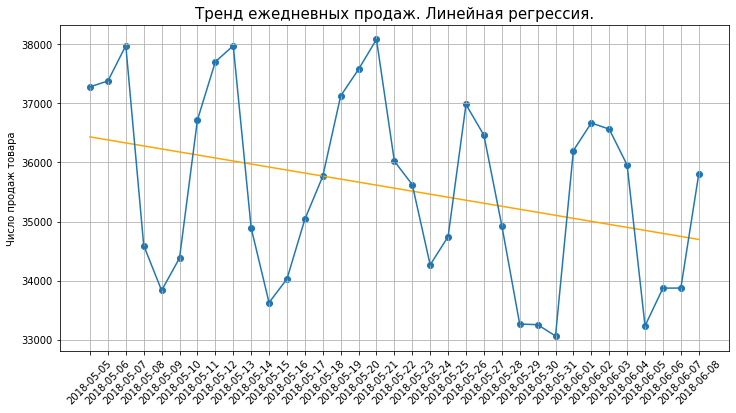

In [209]:
sales_trend(df_35day)

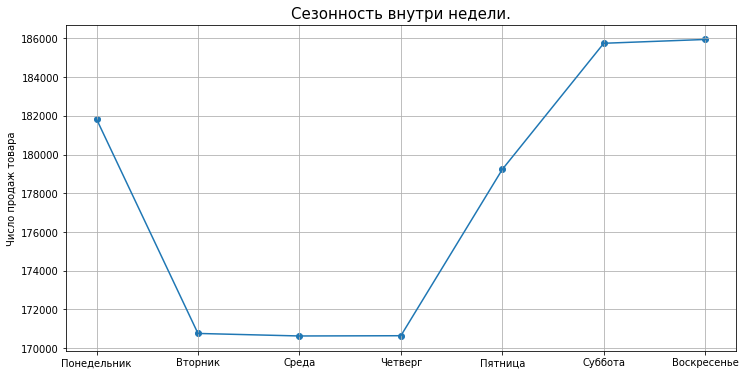

In [210]:
week_cycle(df_35day)

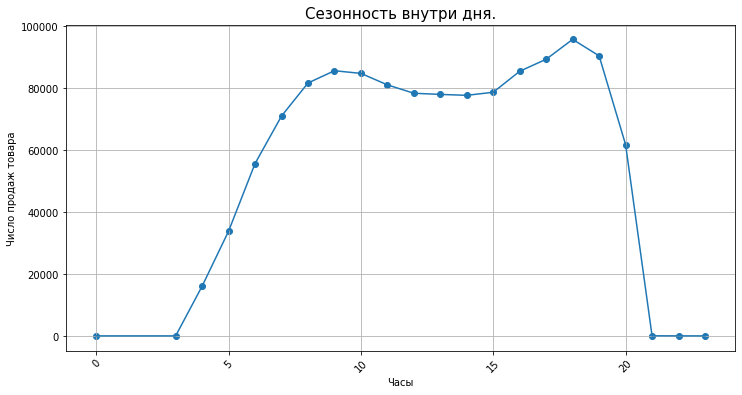

In [211]:
intraday_cycle(df_35day)

# 2. Сделаю прогноз на пятую неделю с помощью линейной регрессии. Проверю метрики качества. Построю график.

In [212]:
def MSE(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

In [213]:
def MAPE(y_true, y_pred):
    return (np.abs(y_true - y_pred) / y_true).mean() 

### Предсказываю число заказов за всю неделю и затем распределяю это число по подневному нормированному профилю недели.

In [214]:
def for_L_Regression(df): # подготовлю данные для прогноза линейной регрессией
    df_cat_day = df.groupby(by=['date'])['num_sells_in_hour'].sum().sort_index()
    df_cat_day2 = df_cat_day.to_frame().reset_index()
    df_cat_day2['date'] = pd.to_datetime(df_cat_day2['date'])
    y_num_sells_in_hour = np.array(df_cat_day2['num_sells_in_hour']).reshape(5, 7)
    y_train = np.sum(y_num_sells_in_hour, axis=1)[:4]
    X = np.arange(5).reshape(-1, 1)
    X_train = X[:4]
    #y_train = y[:4]
    X_test = X[-1:]
    return df_cat_day2, y_num_sells_in_hour, y_train, X_train, X_test

In [215]:
def day_forecast_l_regr(): # считаю нормированный подневный профиль недели
    day_pred = []
    for ind_week in np.sum(y_num_sells_in_hour[:4], axis=0):
        day_pred.append((ind_week / y_num_sells_in_hour[:4].sum()) * y_pred) # считаем нормированный подневный профиль недели
    return day_pred

In [216]:
def MSE_MAPE_lists_l_regr(df, df2): # формирую списки MSE и MAPE
    MAPE_regr = MAPE(np.array((df[-7:]['num_sells_in_hour'])), (np.array(df2)))
    MAPE_list_regr.append(MAPE_regr)
    MSE_regr = MSE(np.array((df[-7:]['num_sells_in_hour'])), (np.array(df2)))
    MSE_list_regr.append(MSE_regr)
    return MSE_list_regr, MAPE_list_regr

In [217]:
MSE_list_regr = []
MAPE_list_regr = []
sells_list_forecast_regr = []
for key_35day_l, ind_35day_l in df_35day.groupby(by=['category_id']):
    df_cat_day2, y_num_sells_in_hour, y_train, X_train, X_test = for_L_Regression(ind_35day_l)
    regr = LinearRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    day_pred = day_forecast_l_regr()
    MSE_list_regr, MAPE_list_regr = MSE_MAPE_lists_l_regr(df_cat_day2, day_pred)
    sells_list_forecast_regr.append(day_pred)

## Посчитаю средние по всем категориям товаров MSE и MAPE для Линейной регрессии.

In [218]:
MSE_mean_regr = np.array(MSE_list_regr).mean()
MSE_mean_regr

1186.3272413666634

In [219]:
MAPE_mean_regr = np.array(MAPE_list_regr).mean()
MAPE_mean_regr

0.11591660301930519

## Построю график.

In [220]:
y_sells_forecast_plt_regr = np.sum(np.array(sells_list_forecast_regr), axis=0)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

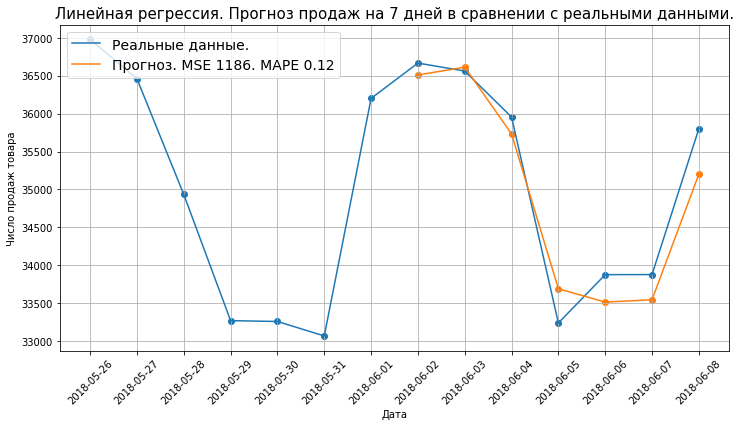

In [221]:
plt.figure(figsize=(12, 6))
plt.grid()
plt.title('Линейная регрессия. Прогноз продаж на 7 дней в сравнении с реальными данными.', fontsize=15)
plt.xlabel(u'Дата')
plt.ylabel(u'Число продаж товара')
plt.xticks(rotation=45)
plt.plot(daily_sells[-14:]['date'], daily_sells[-14:]['num_sells_in_hour'], label='Реальные данные.')
plt.plot(daily_sells[-7:]['date'], y_sells_forecast_plt_regr[-7:], label='Прогноз. MSE {:.0f}. MAPE {:.2f}'.format(MSE_mean_regr, MAPE_mean_regr))
plt.legend(loc=2, prop={'size': 14})
plt.scatter(daily_sells[-14:]['date'], daily_sells[-14:]['num_sells_in_hour'])
plt.scatter(daily_sells[-7:]['date'], y_sells_forecast_plt_regr[-7:])
plt.show()

# 3. Сделаю прогноз с помощью Prophet. Проверю метрики качества. Создам необходимые словари и списки. Построю график.

In [222]:
def Profhet(df):
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=7)
    forecast = m.predict(future)
    return forecast

In [223]:
def df_cat_day(df): # подготовка данных к Prophet
    df_cat_day2 = df.groupby(by=['date'])['num_sells_in_hour'].sum().sort_index().to_frame().reset_index()
    df_cat_day2['date'] = pd.to_datetime(df_cat_day2['date'])
    df_cat_day2.rename(columns={'date':'ds', 'num_sells_in_hour': 'y'}, inplace=True)
    df_cat_day2_28 = df_cat_day2.iloc[:28]
    y_true_7 = df_cat_day2.iloc[-7:]['y']
    return df_cat_day2, df_cat_day2_28, y_true_7

In [224]:
def forecast_fin(df): # формирую словарь с итоговым прогнозом и MAPE по категориям
    forecast_fin = Profhet(df_cat_day2)
    forecast_and_MAPE_list = list(np.array(forecast_fin[-7:]['yhat']))
    forecast_and_MAPE_list.append(MAPE_forecast_cat)
    forecast_final_dict[key_35day] = forecast_and_MAPE_list
    return forecast_final_dict

In [225]:
def MSE_MAPE_lists(df): # формирую списки MSE и MAPE
    y_forecast_cat = np.array(forecast_cat[-7:]['yhat'])
    MSE_list_prophet.append(MSE(y_true_7, y_forecast_cat))
    MAPE_list_prophet.append(MAPE(y_true_7, y_forecast_cat))
    return MSE_list_prophet, MAPE_list_prophet

In [226]:
sells_list_forecast = [] #список продаж из Prophet 28 плюс 7
MAPE_list_prophet = [] # список MAPE по каждой категории
MSE_list_prophet = [] # список MSE по каждой категории
forecast_final_dict = {} # словарь прогноза на 6 неделю
for key_35day, ind_35day in df_35day.groupby(by=['category_id']):
    df_cat_day2, df_cat_day2_28, y_true_7 = df_cat_day(ind_35day)
    forecast_cat = Profhet(df_cat_day2_28)
    sells_list_forecast.append(forecast_cat['yhat'])
    MSE_list_prophet, MAPE_list_prophet = MSE_MAPE_lists(forecast_cat)
    forecast_final_dict = forecast_fin(df_cat_day2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabli

<IPython.core.display.Javascript object>

## Посчитаю средние по всем категориям товаров MSE и MAPE для Prophet.



In [227]:
MSE_mean_prophet = np.array(MSE_list_prophet).mean()
MSE_mean_prophet

879.9797928848981

In [228]:
MAPE_mean_prophet = np.array(MAPE_list_prophet).mean()
MAPE_mean_prophet

0.10289989900183913

## Построю график.

In [229]:
y_sells_forecast_plt = np.sum(np.array(sells_list_forecast), axis=0)
x_data_plt = forecast_cat['ds']
#y_sells_plt = np.sum(np.array(sells_list_true), axis=0)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

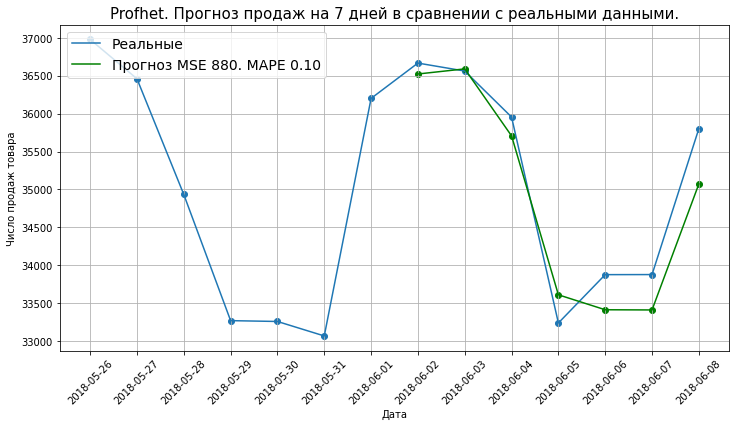

In [230]:
plt.figure(figsize=(12, 6))
plt.grid()
plt.title('Profhet. Прогноз продаж на 7 дней в сравнении с реальными данными.', fontsize=15)
plt.xlabel(u'Дата')
plt.ylabel(u'Число продаж товара')
plt.xticks(rotation=45)
plt.plot(daily_sells[-14:]['date'], daily_sells[-14:]['num_sells_in_hour'], label='Реальные')
plt.plot(daily_sells[-7:]['date'], y_sells_forecast_plt[-7:], label='Прогноз MSE {:.0f}. MAPE {:.2f}'.format(MSE_mean_prophet, MAPE_mean_prophet), color='green')
plt.legend(loc=2, prop={'size': 14})
plt.scatter(daily_sells[-14:]['date'], daily_sells[-14:]['num_sells_in_hour'])
plt.scatter(daily_sells[-7:]['date'], y_sells_forecast_plt[-7:], color='green')
plt.show()

# 4. Сравнение результатов на графике.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

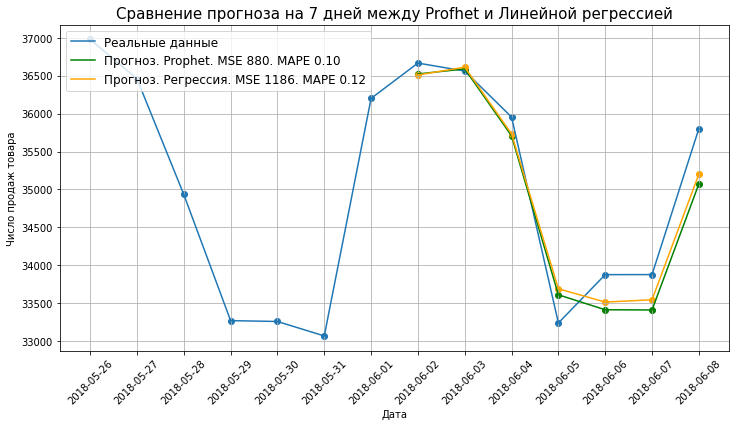

In [231]:
plt.figure(figsize=(12, 6))
plt.grid()
plt.title('Сравнение прогноза на 7 дней между Profhet и Линейной регрессией', fontsize=15)
plt.xlabel(u'Дата')
plt.ylabel(u'Число продаж товара')
plt.xticks(rotation=45)
plt.plot(daily_sells[-14:]['date'], daily_sells[-14:]['num_sells_in_hour'], label='Реальные данные')
plt.plot(daily_sells[-7:]['date'], y_sells_forecast_plt[-7:], label='Прогноз. Prophet. MSE {:.0f}. MAPE {:.2f}'.format(MSE_mean_prophet, MAPE_mean_prophet), color='green')
plt.plot(daily_sells[-7:]['date'], y_sells_forecast_plt_regr[-7:], label='Прогноз. Регрессия. MSE {:.0f}. MAPE {:.2f}'.format(MSE_mean_regr, MAPE_mean_regr), color='orange')
plt.legend(loc=2, prop={'size': 12})
plt.scatter(daily_sells[-14:]['date'], daily_sells[-14:]['num_sells_in_hour'])
plt.scatter(daily_sells[-7:]['date'], y_sells_forecast_plt[-7:], color='green')
plt.scatter(daily_sells[-7:]['date'], y_sells_forecast_plt_regr[-7:], color='orange')
plt.show()

## Визуально результаты близки. По метрикам качества лучше Prophet: MSE = 880, MAPE = 0,1. У Линейной регрессии MSE = 1186 и MAPE = 0,12.

# 5. По резульатам сравнения метрик качества выведем прогноз из Prophet.


In [232]:
df_final = pd.DataFrame(forecast_final_dict).T.reset_index().rename(columns={'index':'category_id', 0:'2018-06-09', 1:'2018-06-10', 2:'2018-06-11', 3:'2018-06-12', 4:'2018-06-13', 5:'2018-06-14', 6:'2018-06-15', 7:'MAPE'})

In [233]:
df_final

,category_id,2018-06-09,2018-06-10,2018-06-11,2018-06-12,2018-06-13,2018-06-14,2018-06-15,MAPE
0,353,152.551278,148.147772,147.146524,137.539617,139.140078,132.535144,144.142184,0.198524
1,388,65.253435,65.456589,69.287661,66.064447,69.492417,50.346673,64.658398,0.198524
2,458,204.054653,212.454121,208.453679,191.053412,195.253247,179.453107,180.052934,0.198524
3,984,222.691331,215.722061,205.573534,202.379633,191.833698,185.261835,188.625153,0.198524
4,994,218.296609,232.061371,206.941677,217.263720,218.269462,207.731190,225.951090,0.198524
...,...,...,...,...,...,...,...,...,...
133,13693,277.038735,290.024796,264.011204,236.198222,260.185942,256.574573,276.563554,0.198524
134,13702,358.339964,371.165326,371.765009,335.488655,318.652526,312.839259,341.698202,0.198524
135,13705,392.088829,395.678348,407.068518,360.658724,366.849797,382.441488,390.633185,0.198524
136,13807,174.470580,185.468510,175.865936,172.263670,174.661616,163.459652,166.858399,0.198524
